<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W3D4_initial/tutorials/W3D4_DeepLearning1/W3D4_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 4, Tutorial 2
# Deep Learning: Encoding Neural Responses

By Carsen Stringer \& Jorge A. Menendez; reviewed by Roozbeh Farhoodi





#Tutorial Objectives

In this tutorial, we'll use deep learning to build an encoding model from stimuli to neural activity. Specifically, we'll be looking at the activity of ~20,000 neurons in mouse primary visual cortex responding to oriented gratings recorded in [this study](https://www.biorxiv.org/content/10.1101/679324v2.abstract). 

Because the stimuli are 1D and the neurons respond with smooth tuning curves, we can model the neural responses as a 1D convolutional operation on the stimulus. 

In this tutorial, we will 
* Understand the basics of convolution
* Build and train a convolutional neural network to predict neural responses using PyTorch
* Visualize and analyze its internal representations

Video available at https://youtube.com/watch?v=kJswpFmva_w


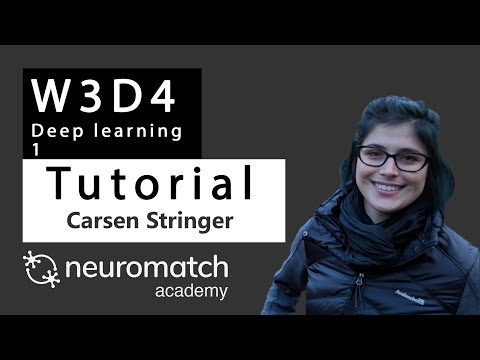

In [1]:
#@title Video: Encoding Models using convolutions
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="kJswpFmva_w", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---
## Setup

**Don't forget to execute the hidden cells below!**

In [2]:
import os
import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# @title Download data

# Download data from OSF
data_filename = 'mouseV1.npy'
if data_filename in os.listdir():
  print('data already downloaded!')
else:
  print('downloading data...')
  !wget -O mouseV1.npy https://osf.io/6g4nz/download

data already downloaded!


In [4]:
#@title Helper Functions

# Matplotlib parameters to make plots look nice
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['figure.figsize'] = (8, 6)

# Some helper functions
def load_data():
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaginge. The responses have been normalized by
  spontanous levels of activity and then z-scored over stimuli, so
  expect negative numbers.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in 
  Google Colab.

  Returns:
    resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in radians

  """
  data = np.load(data_filename, allow_pickle=True).item()

  # Neural responses
  resp = torch.tensor(data['resp'], dtype=torch.float32)
  
  # Stimuli
  stimuli = torch.tensor(data['stimuli'], dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector
  
  return resp, stimuli

def plot_tuning(ax):
  """Plot the tuning curve of a random neuron"""

  neuron_indx = np.random.choice(n_neurons)  # pick random neuron
  ax.plot(np.rad2deg(stimuli), resp[:, neuron_indx], '.')  # plot its responses as a function of stimulus orientation
  
  ax.set_title('neuron %i' % neuron_indx)
  ax.set_xlabel('stimulus orientation ($^o$)')
  ax.set_ylabel('neural response\n (zscored) ')
  ax.set_xticks(np.linspace(0, 360, 5))
  ax.set_ylim([-1,15])

def bin_responses(resp, n_bins=50, training=0.75):
  """ bin neural responses

  Args:
      resp: neural responses (n_stimuli x n_neurons)
      n_bins: number of stim bins
      training: % of data used for training
      h: number of stimulus bins

  Returns:
      respbin_train: binned neural responses on train trials (n_bins x n_neurons)
      respbin_test: binned neural responses on test trials (n_bins x n_neurons)

  """
  # get indices of bins of stimuli
  bins = np.linspace(0, 2*np.pi, n_bins+1)
  stimbin = np.digitize(stimuli[:,0], bins=bins) - 1

  # average neural responses to stimuli in each bin across train and test trials
  respbin_train = torch.zeros((n_bins, n_neurons), dtype=torch.float32)
  respbin_test = torch.zeros((n_bins, n_neurons), dtype=torch.float32)
  for n in range(n_bins):
    rb = resp[stimbin==n]
    n_train = int(0.75 * rb.shape[0])  # putting 75% of data into training set
    ishuffle = torch.randperm(rb.shape[0])
    itrain = ishuffle[:n_train]
    itest = ishuffle[n_train:]
    respbin_train[n] = rb[itrain].mean(axis=0)
    respbin_test[n] = rb[itest].mean(axis=0)

  return respbin_train, respbin_test
  
class progress_bar():
  """Progress bar for displaying progress over neural network training

  Args:
    n_epochs (int): number of epochs that network will be trained for

  Attributes:
    bar (list of str): the current state of the progress bar
    counter (int): counter tracking the current number of epochs run
    n_epochs (int): total number of epochs to be run
  
  """
  
  def __init__(self, n_epochs):
    self.bar = ['|']
    for i in range(n_epochs):
        self.bar.append(' ')
    self.bar.append('|')
    self.counter = 0
    self.n_epochs = n_epochs
  
  def update(self):
    """Update the progress bar and print it"""
    self.counter += 1
    self.bar[self.counter] = '='
    print('%s     (epoch %i/%i complete)' % (''.join(self.bar), self.counter, self.n_epochs))

# from bayes day!
def my_gaussian(x_points, mu, sigma):
  """
  Returns normalized Gaussian estimated at points `x_points`, with parameters: mean `mu` and std `sigma`
  
  Args:
    x_points (numpy array of floats): points at which the gaussian is evaluated
    mu (scalar): mean of the Gaussian
    sigma (scalar): std of the gaussian
  
  Returns: 
    (numpy array of floats) : un-normalized Gaussian (i.e. without constant) evaluated at `x`
  """
  px = np.exp(- 1/2/sigma**2 * (mu - x_points) ** 2)
  px = px / px.sum()
  return px

def plot_conv(pad, stimulus, filter, conv_out):  
  # plot stimulus
  ax = fig.add_subplot(1,3,1)
  ax.plot(np.arange(-pad, 360+pad), stimulus, 'k')
  ax.set_title('stimulus')
  ax.set_xlabel('orientation ($^o$)')
  ax.set_ylabel('stimulus')

  # plot convolutional filter
  ax = fig.add_subplot(1,3,2)
  ax.plot(np.arange(-pad, pad), filter)
  ax.set_xlabel('orientation ($^o$)')
  ax.set_ylabel('magnitude')
  ax.set_title('convolutional filter')

  # plot convolutional output
  ax = fig.add_subplot(1,3,3)
  n_units = (~np.isnan(conv_out)).sum()
  ax.scatter(np.arange(0,n_units), 
             conv_out[~np.isnan(conv_out)], s=30,
             cmap='hsv', c=np.arange(0,n_units))
  ax.set_xlabel('convolutional unit')
  ax.set_ylabel('activation')
  ax.set_title('activations of\nconvolutional units')

# plot example neural responses
def plot_tuning_binned(ax, r1, r2, ineur, colors):
  """ two responses r1 and r2 plotted """
  ax.plot(r1, colors[0])
  ax.plot(r2, colors[1])
  ax.set_xlabel('stimulus orientation bin')
  ax.set_ylabel('neuron response\n (z-scored)')
  ax.set_title('neuron %d'%ineur)

def plot_example_activations(act):
  """ plot activations act and corresponding stimulus 
  Args:
        act: activations of convolutional layer (n_bins x conv_channels x n_bins)
  """
  ns = [10,25,40]
  fig, axs = plt.subplots(1,3,figsize=(12,4))
  for k, (n, ax) in enumerate(zip(ns, axs.flatten())):
    ax.plot(n * np.ones(2), [act.min()*1.15, act.max()*1.15], 'k', linewidth=4)
    ax.plot(act[n].T, linewidth=2)
    ax.set_xlabel('convolutional unit')
    ax.set_ylabel('activation')
    ax.set_title('stim id %d'%n)
    leg = ['chan%d'%i for i in range(act.shape[1])]
    leg.insert(0, 'stim')
    n_units = act.shape[0]
    for k,s in enumerate(leg):
      if k==0:
        ax.text(((n+20)%n_units)/n_units, .9-k*.1, s, transform=ax.transAxes, color='k', ha='center')
      else:
        ax.text(((n+20)%n_units)/n_units, .9-k*.1, s, transform=ax.transAxes, color='C%d'%(k-1), ha='center')
  plt.tight_layout()
  plt.show()

def plot_pred_weights(y_pred, weights):
  ### plot example neural response prediction
  plt.subplot(1,2,1)
  plt.plot(y_pred)
  plt.title('neuron prediction')
  plt.xlabel('stimulus bin')
  plt.ylabel('response')

  ### plot weights of fully-connected layer for first 300 neurons
  plt.subplot(1,2,2)
  plt.imshow(weights, aspect='auto')
  plt.title('out_layer weights')
  plt.ylabel('neurons')
  plt.xlabel('convolutional units')

  plt.tight_layout()
  plt.show()

def get_hidden_activity(net, stimuli, layer_labels):
  """Retrieve internal representations of network

  Args:
    net (nn.Module): deep network
    stimuli (torch.Tensor): p x 48 x 64 tensor with stimuli for which to 
      compute and retrieve internal representations
    layer_labels (list): list of strings with labels of each layer for which
      to return its internal representations

  Returns:
    dict: internal representations at each layer of the network, in
      numpy arrays. The keys of this dict are the strings in layer_labels.

  """

  # Placeholder
  hidden_activity = {}

  # Attach 'hooks' to each layer of the network to store hidden
  # representations in hidden_activity
  def hook(module, input, output):
    module_label = list(net._modules.keys())[np.argwhere([module == m for m in net._modules.values()])[0, 0]]
    if module_label in layer_labels:  # ignore output layer
      hidden_activity[module_label] = output.view(stimuli.shape[0], -1).detach().numpy()
  hooks = [layer.register_forward_hook(hook) for layer in net.children()]

  # Run stimuli through the network
  pred = net(stimuli)
  
  # Remove the hooks
  [h.remove() for h in hooks]

  return hidden_activity

def plot_prediction(ax, y_pred, y_test):
  ax.plot(y_test,color='y')
  ax.plot(y_pred, 'g')
  ax.set_xlabel('stimulus bin')
  ax.set_ylabel('response')
  


---
## Visualize many neurons' tuning curves and look at convolutions

Observe the diversity of tuning curves in the population. You can rerun this cell, looking at a random subset of neurons each time. 

How can we fit these neural responses with an encoding model?

resp contains responses of 23589 neurons to 4598 stimuli


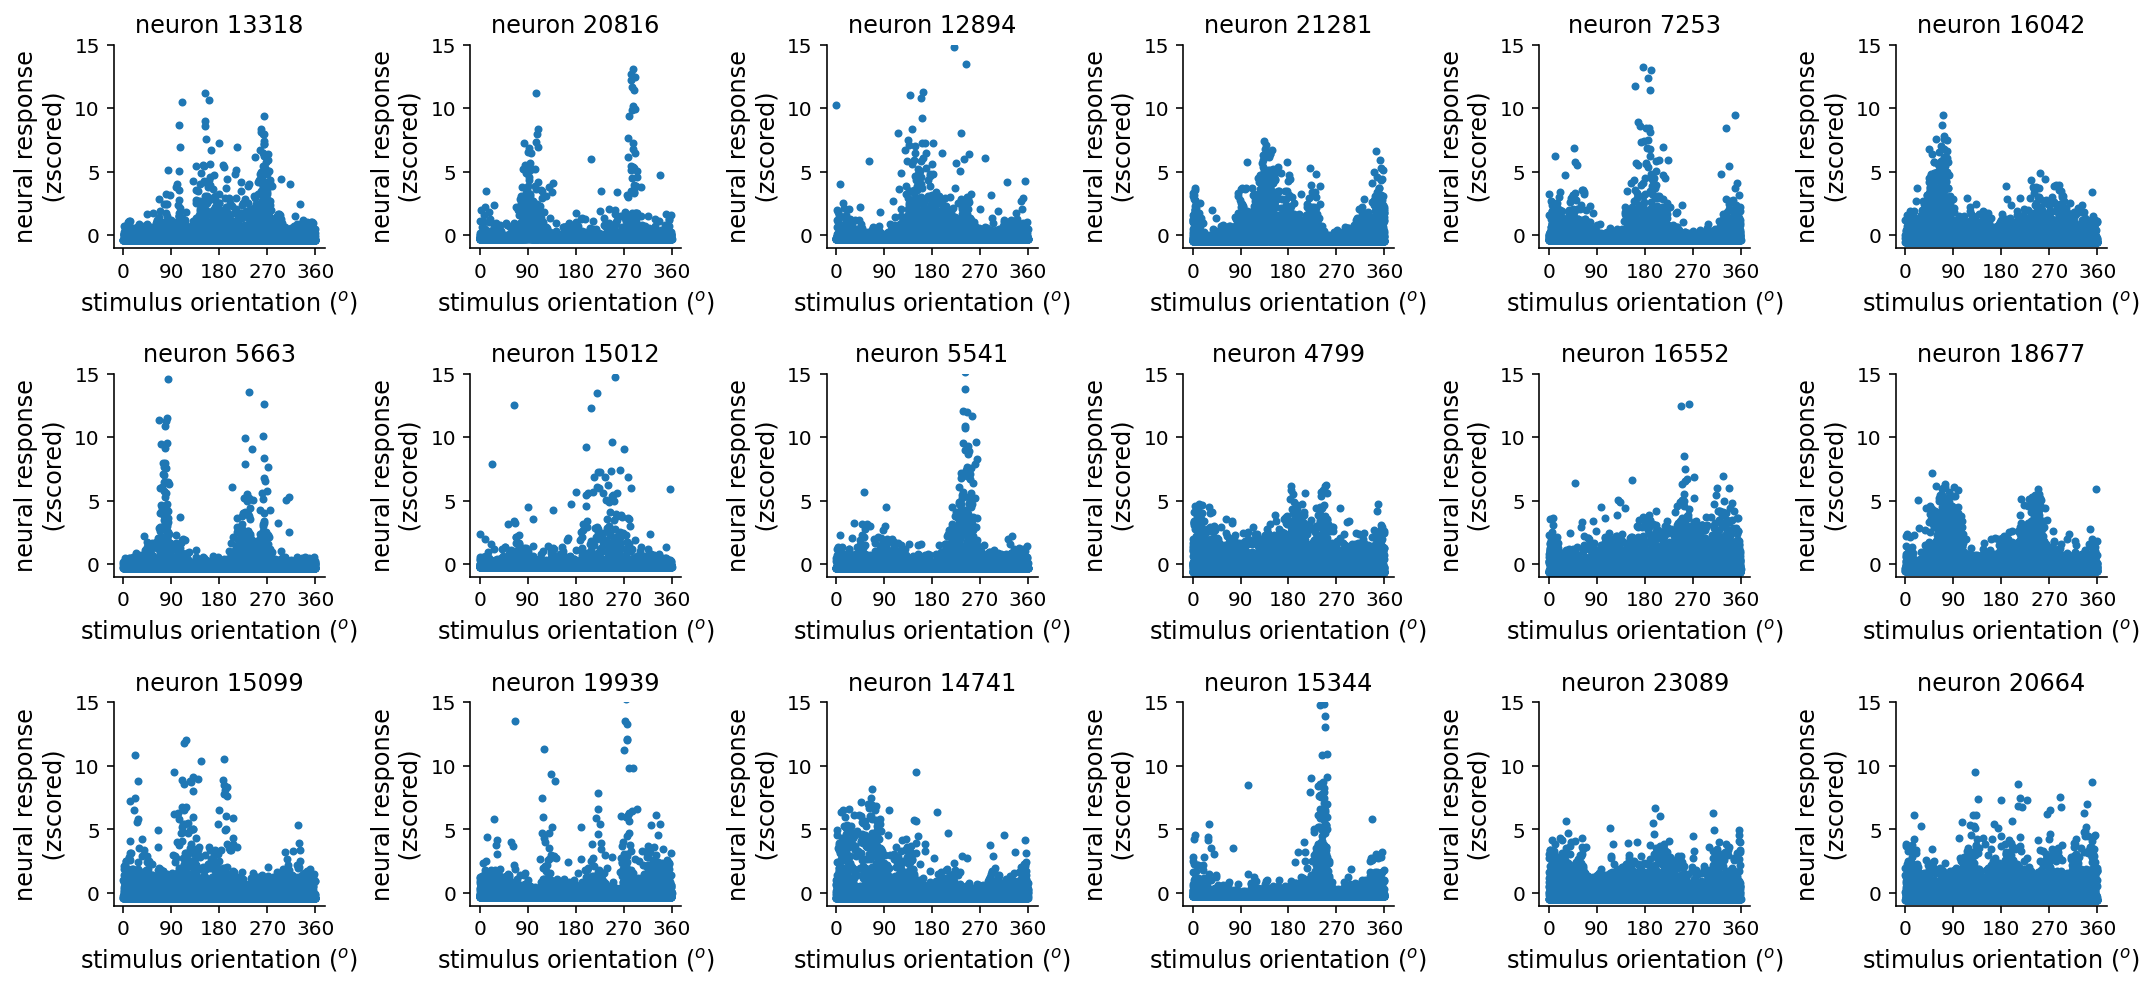

In [5]:
# Load data
resp, stimuli = load_data()
n_stimuli, n_neurons = resp.shape
print('resp contains responses of %i neurons to %i stimuli' % (n_neurons, n_stimuli))

# Visualize tuning curves
fig, axs = plt.subplots(3, 6, figsize=(15,7))
for ax in axs.flatten():
  plot_tuning(ax)
fig.tight_layout()
plt.show()


### Exercise 1

Perform a 1D convolution of a stimulus input $s$ with **filter** $f$ of size $K$ (these filters are also called *kernels*).

$a_x = \sum^{K/2}_{i=-K/2} f_i \, s_{x-i}$

**Hints**
* create a loop over $x$ (stimulus positions)
* use vector operations to perform the sum (element-wise multiplication +  `.sum()`)

In [6]:
### convolutional parameters
K = 49 # size of convolutional filter
stride = 1 # how often to compute the convolution along the stim axis
pad = K // 2 # we will need to pad stimulus with zeros to perform convolution

### stimulus is 0 in all places except stimulus orientation
ori = np.random.choice(360)
stimulus = np.zeros(360+2*pad) # pad stimulus by -pad / +pad
stimulus[ori+pad] = 1.0

### filter is a gaussian
# we will use the code from W2D1 (bayes day) to create this!
# mean of gaussian mu=0
i = np.arange(-pad, pad)
f = my_gaussian(i, 0.0, sigma=10)

### compute the convolution
a = np.nan * np.zeros(360)  # initialize convolutional output
################################################################################
## TO DO for students: compute convolution activations using filter and stimulus
################################################################################
# for x in np.arange(0+pad, 360+pad, ..., int): # loop over positions x, what is spacing in loop?
#   compute element-wise multiplication between filter f and stimulus
#   a[x-pad] = (...).sum() 

##  TO DO for students: uncomment the lines below for plotting 
#fig = plt.figure(figsize=(15,3))
#plot_conv(ori, stimulus, f, a)

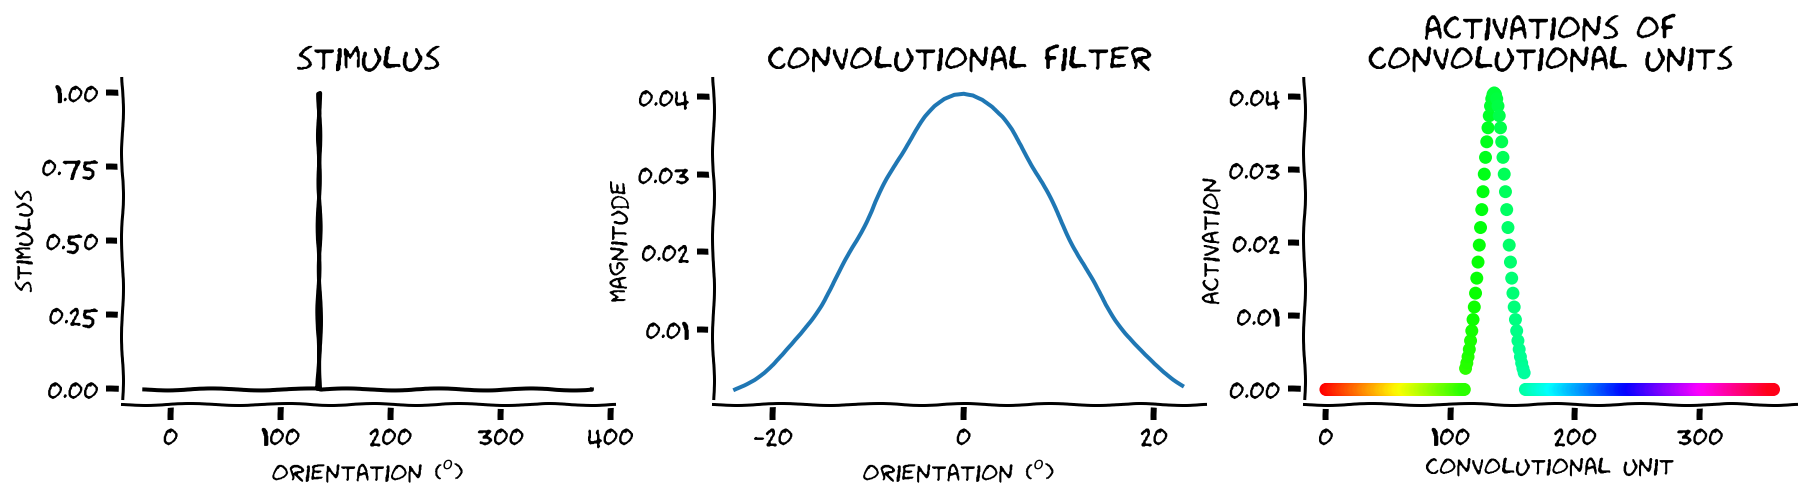

In [7]:
# to_remove solution

### convolutional parameters
K = 49 # size of convolutional filter
stride = 1 # how often to compute the convolution along the stim axis
pad = K // 2 # we will need to pad stimulus with zeros to perform convolution

### stimulus is 0 in all places except stimulus orientation
ori = 135#np.random.choice(360)
stimulus = np.zeros(360+2*pad) # pad stimulus by -pad / +pad
stimulus[ori+pad] = 1.0

### f is a gaussian
# we will use the code from W2D1 (bayes day) to create this!
# mean of gaussian mu=0
i = np.arange(-pad, pad)
f = my_gaussian(i, 0.0, sigma=10)

### compute the convolution
a = np.nan * np.zeros(360) # initialize convolutional output
for x in np.arange(0+pad, 360+pad, stride, int): # loop over positions x
  # compute element-wise multiplication between filter and stimulus
  a[x-pad] = (f * stimulus[x-pad : x+pad]).sum()

with plt.xkcd():
  fig = plt.figure(figsize=(15,3))
  plot_conv(pad, stimulus, f, a)
  plt.show()

## **Convolutional layers**

You have just learned how to compute what is called a single convolutional **channel**: a single filter applied to the input resulting in several units, where the number of units depends on the *stride* you set.

(Note if filter size *K* is odd and you set the *pad=K//2* and *stride=1* (as is the default above), you get a **channel** of units that is the same size as the input.)

*Contemplation:* How does a neuron potentially combine those activation units and create the tuning curves they have? Will we need more than one convolutional filter to recreate all the responses we see?

Let's add more convolutional channels and implement this operation efficiently using pytorch. A *layer* of convolutional channels can be implemented with one line of code using the PyTorch class `nn.Conv1d()`, which requires the following arguments for initialization:
  * $C^{in}$: the number of input channels
  * $C^{out}$: the number of output channels (number of different convolutional filters)
  * $K$: the size of the $C^{out}$ different convolutional filters
  
When you run the network, you can input a stimulus of arbitrary length ($H^{in}$), but it needs to be shaped as a 2D input $C^{in} \times H^{in}$. In our case, $C^{in}=1$ because there is only one orientation input.

In [8]:
class ConvolutionalLayer(nn.Module):
  """Deep network with one convolutional layer

    Attributes:
      conv (nn.Conv1d): convolutional layer
    """
  
  def __init__(self, c_in=1, c_out=8, K=7):
    """ initialize layer
    Args:
        c_in: number of input stimulus channels
        c_out: number of output convolutional channels
        K: size of each convolutional filter
    """
    super().__init__()
    self.conv = nn.Conv1d(c_in, c_out, kernel_size=K, 
                          padding=K//2, stride=1)
    
  def forward(self, x):
    """Run stimulus through convolutional layer

    Args:
        x (torch.Tensor): p x h tensor with stimuli
    
    Returns:
        torch.Tensor: p x c_out x h tensor with convolutional layer unit activations.

    """
    x = x.unsqueeze(1)  # p x 1 x h, add a singleton dimension for the single channel
    x = self.conv(x)  # output of convolutional layer
  
    return x



Let's run the stimuli through our convolutional layer and look at activations of different channels. 

But first, let's bin the neural activity across stimuli. Before we bin, we split the stimuli into training and testing sets. Then we bin the stimuli into 50 different bins and average a neuron's response to all training stimuli within each bin, and to all testing stimuli within each bin. This results in two tuning curves for each neuron, visualized in the plot below. Blue is the binned response using training trials, and yellow is the binned response using testing trials.

We will then predict these averaged responses.

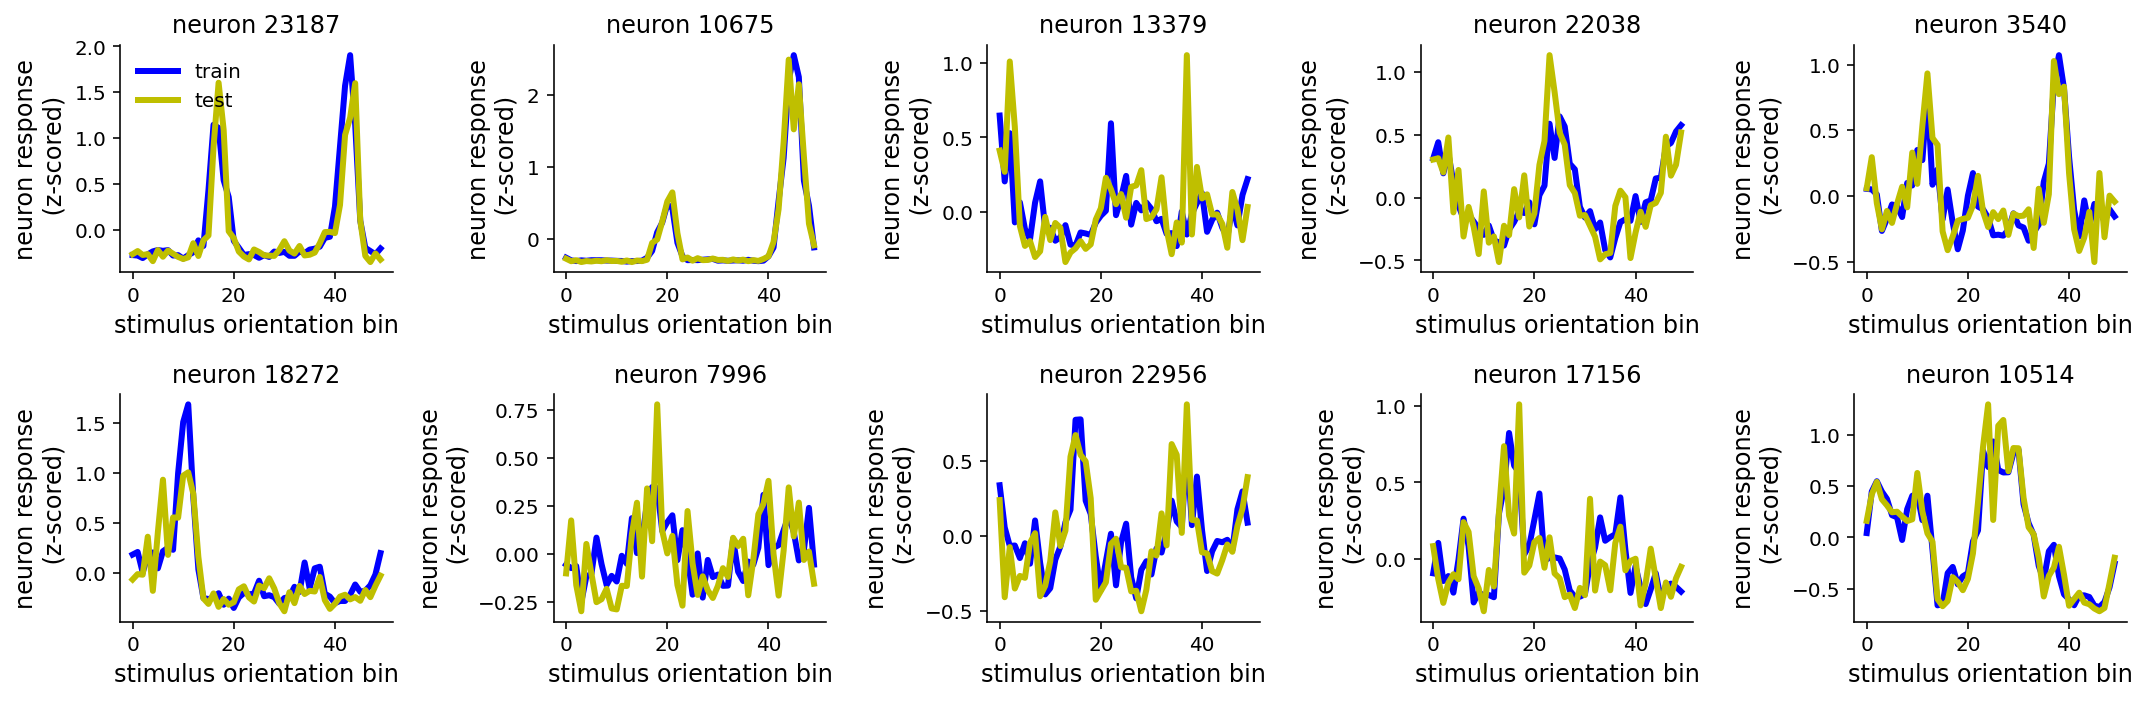

In [9]:
n_bins = 50

# make stimuli into array of 0's and 1's
stim_binary = torch.eye(n_bins, dtype=torch.float32)
 
# use helper function bin_responses
respbin_train, respbin_test = bin_responses(resp, n_bins=n_bins, training=0.75)

# plot binned responses in subplots
fig,axs = plt.subplots(2,5, figsize=(15,5))
for k, ax in enumerate(axs.flatten()):
  ineur = np.random.choice(n_neurons)
  plot_tuning_binned(ax, respbin_train[:,ineur], respbin_test[:,ineur], ineur, ['b', 'y'])
  if k==0:
    ax.legend(['train', 'test'])
plt.tight_layout()
plt.show()

Example stimulus:

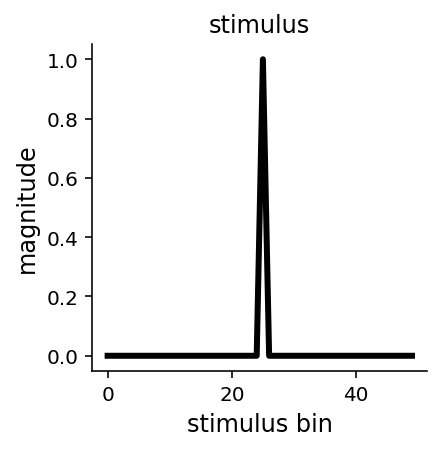

In [10]:
plt.figure(figsize=(3,3))
plt.plot(stim_binary[25], 'k')
plt.xlabel('stimulus bin')
plt.ylabel('magnitude')
plt.title('stimulus')
plt.show()

#### Exercise 2
Now put these stimuli into your convolutional layer!

Can you guess what the shape of the output of the convolutional layer `out` should be?

In [11]:
K = 9 # now that we've binned let's make this smaller
conv_channels = 8 # how many convolutional channels to have in our layer

convout = np.zeros(0) # assign convolutional activations to convout
################################################################################
## TO DO for students: compute convolution activations from stim_binary using pytorch
################################################################################
# convLayer = ConvolutionalLayer(...)
# convout = convLayer(...) 

print(convout.shape) # can you identify what each of these dimensions are?

# Uncomment below to plot the activations
# plot_example_activations(convout)

(0,)


torch.Size([50, 8, 50])


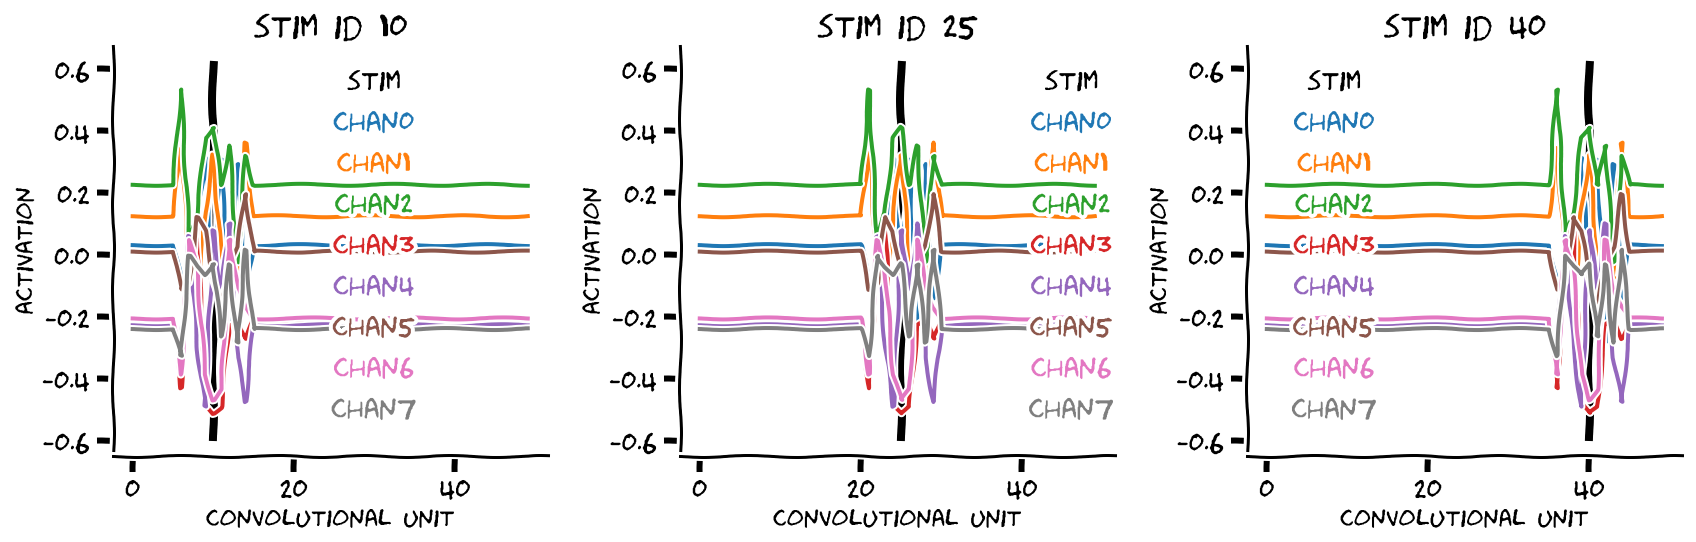

In [12]:
# to_remove solution

K = 9 # now that we've binned let's make this smaller
conv_channels = 8 # how many convolutional channels to have in our layer

convLayer = ConvolutionalLayer(c_in=1, c_out=conv_channels, K=K)
convout = convLayer(stim_binary)
convout = convout.detach() # detach gradients

print(convout.shape) # can you identify what each of these dimensions are?
with plt.xkcd():
  plot_example_activations(convout)

## Convolutional layer + fully connected layer

Now we will hook this convolutional layer up to a fully connected layer like the one that we used in the last tutorial (`nn.Linear`).



#### Exercise 3
* Add a fully connected layer to `__init__` method of network.
* Add a fully connected layer to `forward` method of network.

In [13]:
class ConvFC(nn.Module):
  """Deep network with one convolutional layer + one fully connected layer

  Attributes:
    conv (nn.Conv1d): convolutional layer
    dims (tuple): shape of convolutional layer output
    out_layer (nn.Linear): linear layer 
    
  """
  
  def __init__(self, n_neurons, c_in=1, c_out=8, K=9, b=50):
    """ initialize layer
    Args:
        c_in: number of input stimulus channels
        c_out: number of convolutional channels
        K: size of each convolutional filter
        h: number of stimulus bins, n_bins
    """
    super().__init__()
    self.conv = nn.Conv1d(c_in, c_out, kernel_size=K, padding=K//2)
    self.dims = (c_out, b)  # dimensions of conv layer output
    M = np.prod(self.dims) # number of hidden units
    
    ################################################################################
    ## TO DO for students: add fully connected layer to network (self.out_layer)
    #  self.out_layer = nn.Linear(M, ...)
    ################################################################################
    raise NotImplementedError("Student exercise: add fully connected layer to initialize network")

    nn.init.normal_(self.out_layer.weight, std=0.01) # initialize weights to be small

  def forward(self, s):
    """ Predict neural responses to stimuli s

    Args:
        s (torch.Tensor): p x L tensor with stimuli
    
    Returns:
        torch.Tensor: p x N tensor with convolutional layer unit activations.

    """
    s = s.unsqueeze(1)  # p x 1 x L, add a singleton dimension for the single channel
    h = self.conv(s)  # output of convolutional layer
    h = h.view(-1, np.prod(self.dims))  # flatten each convolutional layer output into a vector
    ################################################################################
    ## TO DO for students: add fully connected layer to forward pass of network (self.out_layer)
    #  y = ...(h)
    #  return y
    ################################################################################
    raise NotImplementedError("Student exercise: add fully connected layer to network")
    

In [14]:
# to_remove solution
class ConvFC(nn.Module):
  """Deep network with one convolutional layer + one fully connected layer

    Attributes:
      conv (nn.Conv1d): convolutional layer
      dims (tuple): shape of convolutional layer output
      out_layer (nn.Linear): linear layer 

  """
  
  def __init__(self, n_neurons, c_in=1, c_out=8, K=9, b=50):
    """ initialize layer
    Args:
        c_in: number of input stimulus channels
        c_out: number of convolutional channels
        K: size of each convolutional filter
        b: number of stimulus bins, n_bins
    """
    super().__init__()
    self.conv = nn.Conv1d(c_in, c_out, kernel_size=K, padding=K//2)
    self.dims = (c_out, b)  # dimensions of conv layer output
    M = np.prod(self.dims)
    self.out_layer = nn.Linear(M, n_neurons)  # flattened conv output --> neurons
    nn.init.normal_(self.out_layer.weight, std=0.01) # initialize weights to be small

  def forward(self, s):
    """ Predict neural responses to stimuli s

    Args:
        s (torch.Tensor): p x L tensor with stimuli
    
    Returns:
        torch.Tensor: p x N tensor with convolutional layer unit activations.

    """
    s = s.unsqueeze(1)  # p x 1 x L, add a singleton dimension for the single channel
    h = self.conv(s)  # output of convolutional layer
    h = h.view(-1, np.prod(self.dims))  # flatten each convolutional layer output into a vector
    y = self.out_layer(h)
    return y



Now run stimuli through network:

output shape:  torch.Size([50, 23589])
weights shape:  torch.Size([23589, 400])


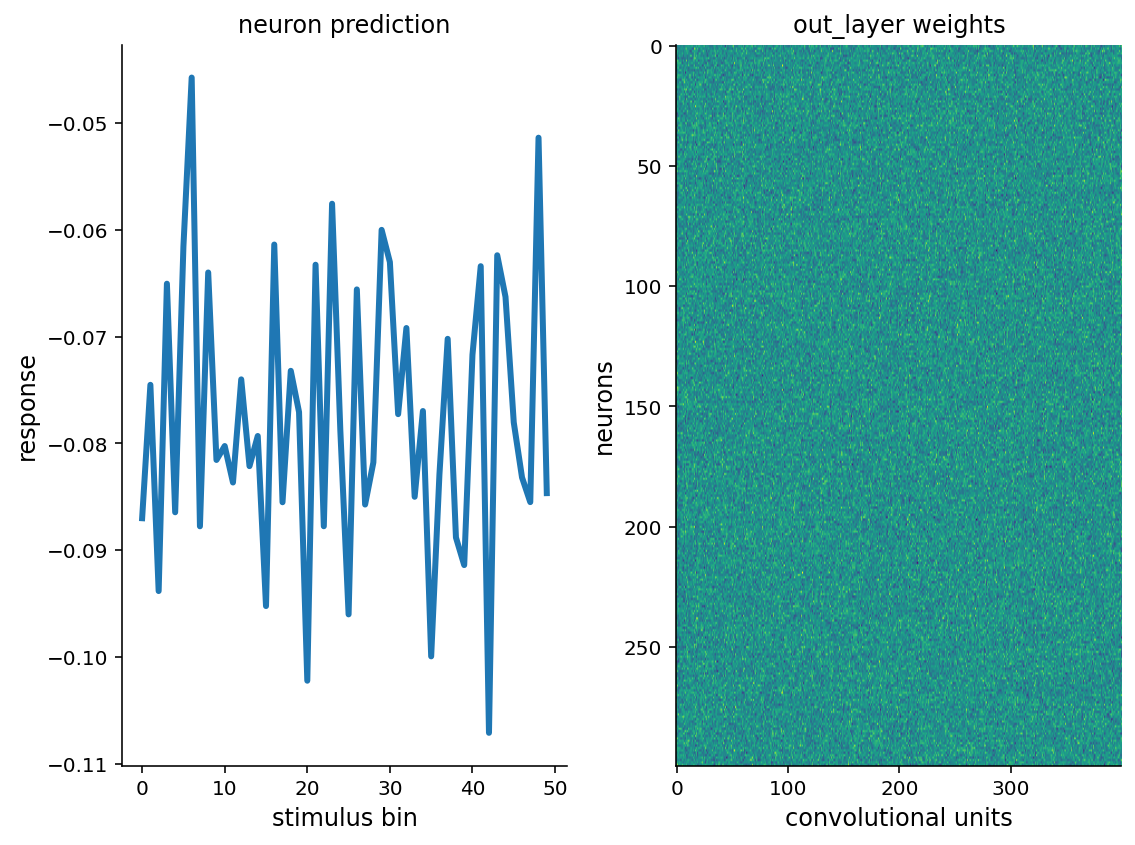

In [15]:
### initialize network
conv_channels = 8
net = ConvFC(n_neurons, c_out=conv_channels)

### input stimuli to network
y_pred = net(stim_binary)
print('output shape: ', y_pred.shape) # what are the two dimensions of this network output?

### plot example neural response prediction and some fully-connected layer weights
# we will look at the weights of the out_layer of the network
weights = net.out_layer.weight.detach()
print('weights shape: ', weights.shape) # what are these two dimensions of the fully connected layer weights?
plot_pred_weights(y_pred[:,0].detach(), weights[:300])


This output doesn't look like the tuning curves we saw before. Based on the tuning curves, we expect the network to sum a few convolutional channels at a few positions along the stimulus dimension. How can we restrict the fully connected layer to only have sparse weights?

Video available at https://youtube.com/watch?v=bIMs0k69m_o


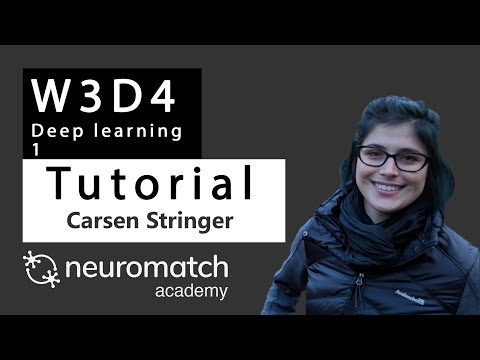

In [16]:
#@title Video: Regularization
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="bIMs0k69m_o", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---
## Regularization

As discussed in the lecture, it is often important to incorporate regularization terms into the loss function to avoid overfitting. In particular, in this case, we want to use these terms to enforce sparsity in the output layer. 

Here we'll consider the classic L2 regularization penalty $\mathcal{R}_{L2}$, which is the sum of squares of each weight in the network $\sum_{ij} {\mathbf{W}^{out}_{ij}}^2$ times a constant that we call `L2_penalty`.

We will also add an L1 regularization penalty $\mathcal{R}_{L1}$ to enforce sparsity of the weights, which is the sum of the absolute values of the weights $\sum_{ij} |{\mathbf{W}^{out}_{ij}}|$ times a constant that we call `L1_penalty`.

We will add both of these to the loss function:
\begin{equation}
    L = (y - \tilde{y})^2 + \mathcal{R}_{L2} + \mathcal{R}_{L1}
\end{equation}

The parameters `L2_penalty` and `L1_penalty` are inputs to the train function.

#### Exercise 4
* add an L2 loss penalty to the weights in the fully-connected layer
* add an L1 loss penalty to the weights in the fully-connected layer
* train the network to predict neural responses

(Hint: see the plotting cell above to learn how to access the weights of a layer)


In [17]:
### train network with train function
def train(net, train_data, train_labels, learning_rate=10, n_epochs=500, L2_penalty=0., L1_penalty=0.):
  """Run gradient descent for network without batches
  
  Args:
    net (nn.Module): deep network whose parameters to optimize with SGD
    train_data: training data (n_train x input features)
    train_labels: training labels (n_train x output features)
    learning_rate (float): learning rate for gradient descent
    n_epochs (int): number of epochs to run gradient descent
    L2_penalty (float): magnitude of L2 penalty
    L1_penalty (float): magnitude of L1 penalty
  """
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5) # Initialize PyTorch SGD optimizer
  loss_fn = nn.MSELoss(reduction='mean') # PyTorch mean squared error loss function
  track_loss = []  # Placeholder for loss
  pbar = progress_bar(n_epochs) # Progress bar to track progress

  # Loop over epochs
  for i in range(n_epochs):
    y_pred = net(train_data) # Forward pass: compute predicted y by passing train_data to the model.

    ### Compute loss
    loss = loss_fn(y_pred, train_labels)
    ################################################################################
    ## TO DO for students: add L1 and L2 penalties to the loss function
    #  L2 = L2_penalty * torch.square(...).sum() # add L2 penalty
    #  L1 = L1_penalty * torch.abs(...).sum() # add L1 penalty
    #  loss += L2 + L1
    ################################################################################
    raise NotImplementedError("Student exercise: add L2 and L1 loss to network")
    

    ### Update parameters
    optimizer.zero_grad() # zero out gradients
    loss.backward() # Backward pass: compute gradient of the loss with respect to model parameters
    optimizer.step() # step parameters in gradient direction
    track_loss.append(loss.item())  # .item() transforms the tensor to a scalar and does .detach() for us

    # Track progress
    if i%50==0:
      pbar.update()
      print('epoch %d L1 %0.5f L2 %0.5f loss %0.5f'%(i, L1.item(), L2.item(), loss.item()))

  ### Plot the loss
  plt.plot(track_loss)
  plt.xlabel('iterations of stochastic gradient descent')
  plt.ylabel('mean squared error loss')
  plt.show()

### initialize network
net = ConvFC(n_neurons)

### train network
# Uncomment when you have implemented the train function
# train(net, stim_binary, respbin_train, L1_penalty=1e-6, L2_penalty=1e-4, learning_rate=10, n_epochs=500)


|=                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |     (epoch 1/500 complete)
epoch 0: L1 loss 0.07525; L2 loss 0.09428; total loss 0.30168
|==                                                                                                                                                                                                                                                                                                                                                                                                                     

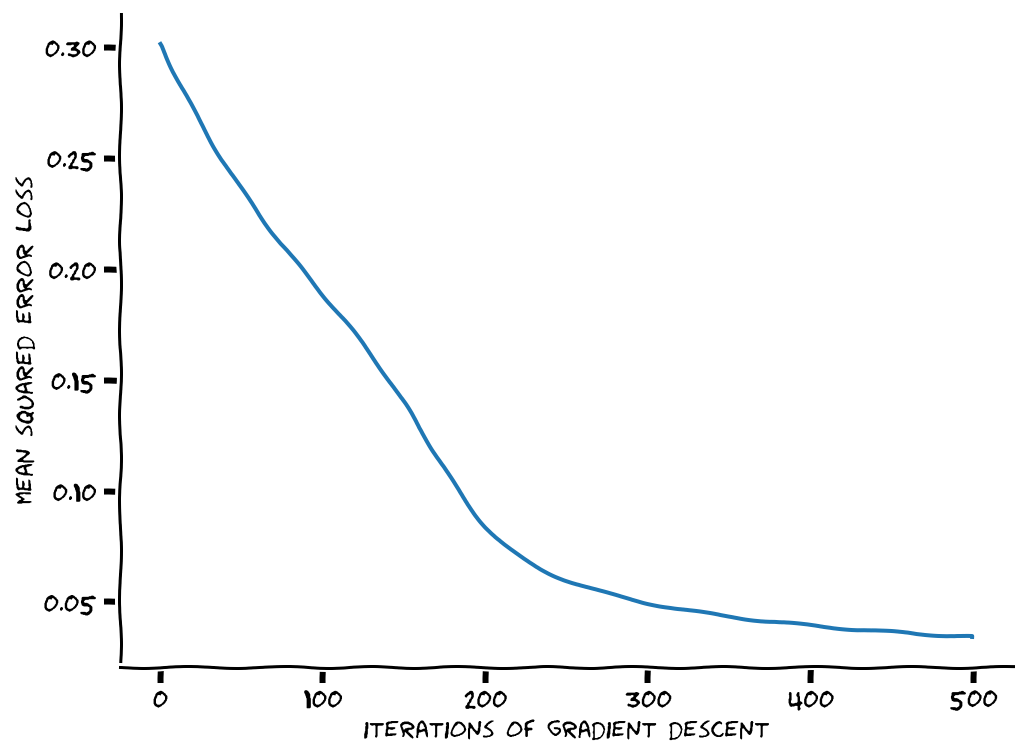

In [18]:
# to_remove solution
### train network with train function
def train(net, train_data, train_labels, learning_rate=10, n_epochs=500, L2_penalty=0., L1_penalty=0.):
  """Run gradient descent for network without batches
  
  Args:
    net (nn.Module): deep network whose parameters to optimize with SGD
    train_data: training data (n_train x input features)
    train_labels: training labels (n_train x output features)
    learning_rate (float): learning rate for gradient descent
    n_epochs (int): number of epochs to run gradient descent
    L2_penalty (float): magnitude of L2 penalty
    L1_penalty (float): magnitude of L1 penalty
  """
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5) # Initialize PyTorch SGD optimizer
  loss_fn = nn.MSELoss(reduction='mean') # PyTorch mean squared error loss function
  track_loss = []  # Placeholder for loss
  pbar = progress_bar(n_epochs) # Progress bar to track progress

  # Loop over epochs
  for i in range(n_epochs):
    y_pred = net(train_data) # Forward pass: compute predicted y by passing train_data to the model.

    ### Compute loss
    loss = loss_fn(y_pred, train_labels)
    L2 = L2_penalty * torch.square(net.out_layer.weight).sum() # add L2 penalty
    L1 = L1_penalty * torch.abs(net.out_layer.weight).sum() # add L1 penalty
    loss += L2 + L1

    ### Update parameters
    optimizer.zero_grad() # zero out gradients
    loss.backward() # Backward pass: compute gradient of the loss with respect to model parameters
    optimizer.step() # step parameters in gradient direction
    track_loss.append(loss.item())  # .item() transforms the tensor to a scalar and does .detach() for us

    # Track progress
    if i%50==0:
      pbar.update()
      print('epoch %d: L1 loss %0.5f; L2 loss %0.5f; total loss %0.5f'%(i, L1.item(), L2.item(), loss.item()))

  ### Plot the loss
  plt.plot(track_loss)
  plt.xlabel('iterations of gradient descent')
  plt.ylabel('mean squared error loss')
  plt.show()


### initialize network
net = ConvFC(n_neurons)

### train network
with plt.xkcd():
  train(net, stim_binary, respbin_train, L1_penalty=1e-6, L2_penalty=1e-4, learning_rate=10, n_epochs=500)

Now let's visualize the trained weights for 10 neurons, what can you see?






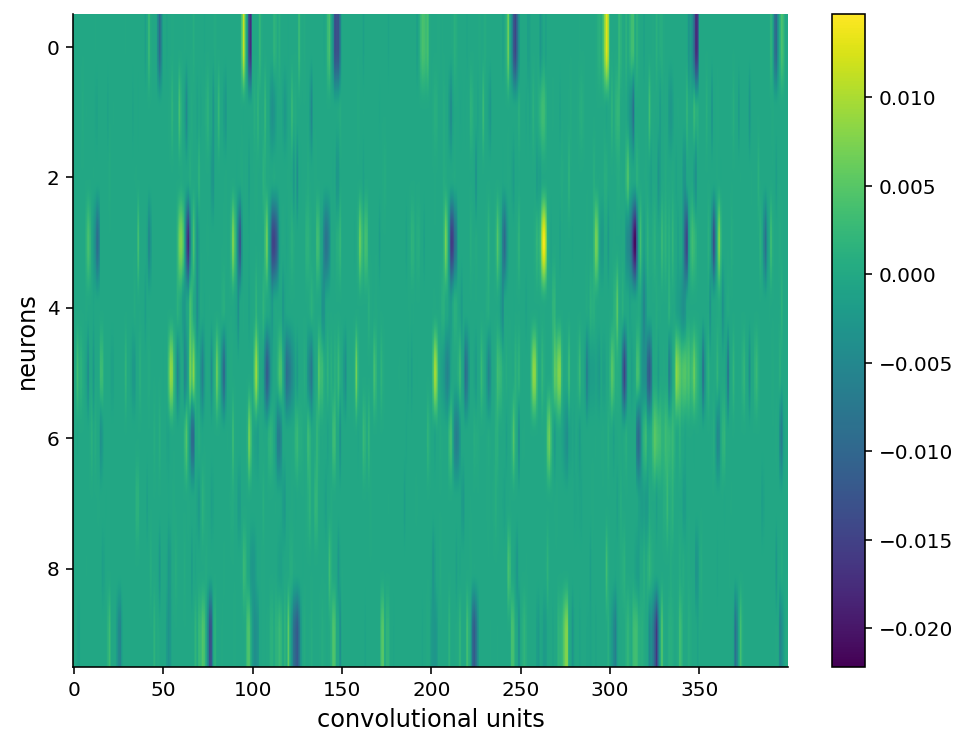

In [19]:
### get weights from network
weights = net.out_layer.weight.detach()

### plot weights
plt.imshow(weights[:10], aspect='auto')
plt.ylabel('neurons')
plt.xlabel('convolutional units')
plt.colorbar()
plt.show()

Now let's look at the activity of the convolutional layers using a helper function that returns the activations if you give the names as a list:


In [20]:
help(get_hidden_activity)

Help on function get_hidden_activity in module __main__:

get_hidden_activity(net, stimuli, layer_labels)
    Retrieve internal representations of network
    
    Args:
      net (nn.Module): deep network
      stimuli (torch.Tensor): p x 48 x 64 tensor with stimuli for which to 
        compute and retrieve internal representations
      layer_labels (list): list of strings with labels of each layer for which
        to return its internal representations
    
    Returns:
      dict: internal representations at each layer of the network, in
        numpy arrays. The keys of this dict are the strings in layer_labels.



activations shape:  (50, 8, 50)


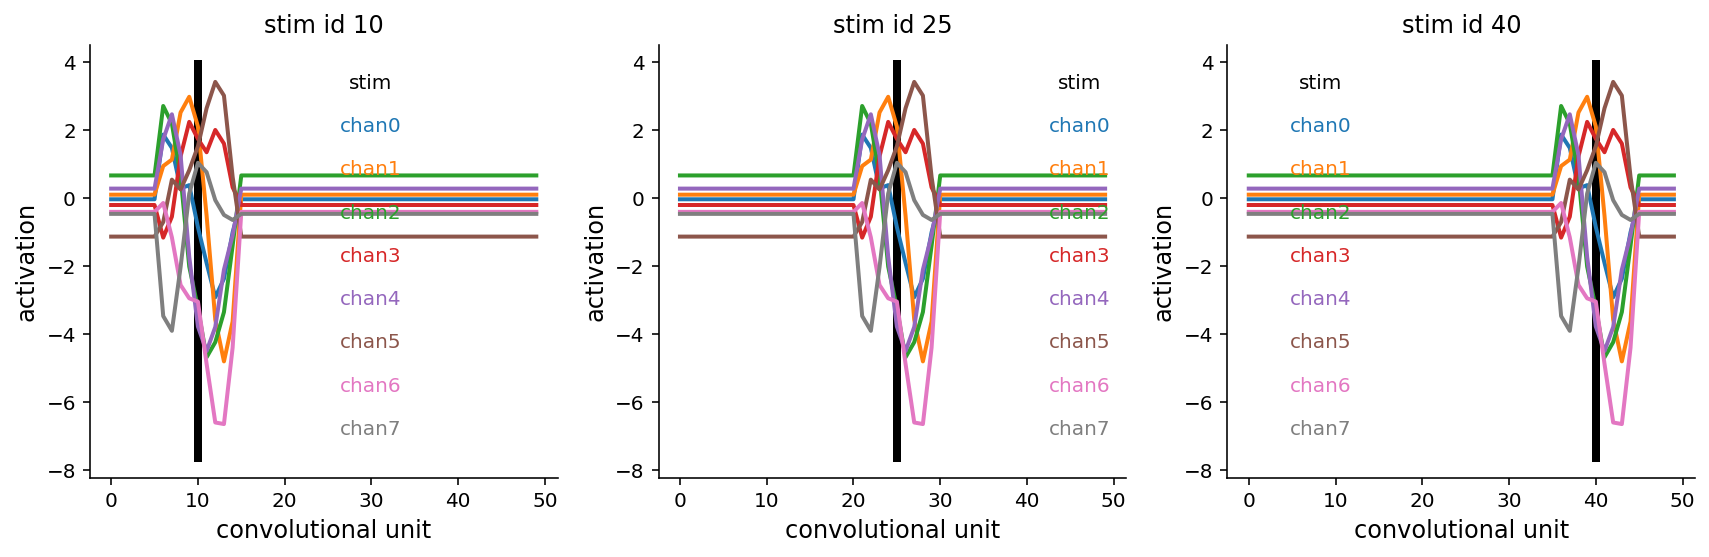

In [21]:
### I've only added one conv layer in this model so we'll just grab that
layer_labels = ['conv'] # get activations for 'conv' layer

idx = 25
resp_model = get_hidden_activity(net, stim_binary, layer_labels)
conv_activations = resp_model['conv']
conv_activations = np.reshape(resp_model['conv'], (n_bins, -1, n_bins))
print('activations shape: ', conv_activations.shape)

### plot activations
plot_example_activations(conv_activations)


Now let's look at what the predictions look like for some neurons

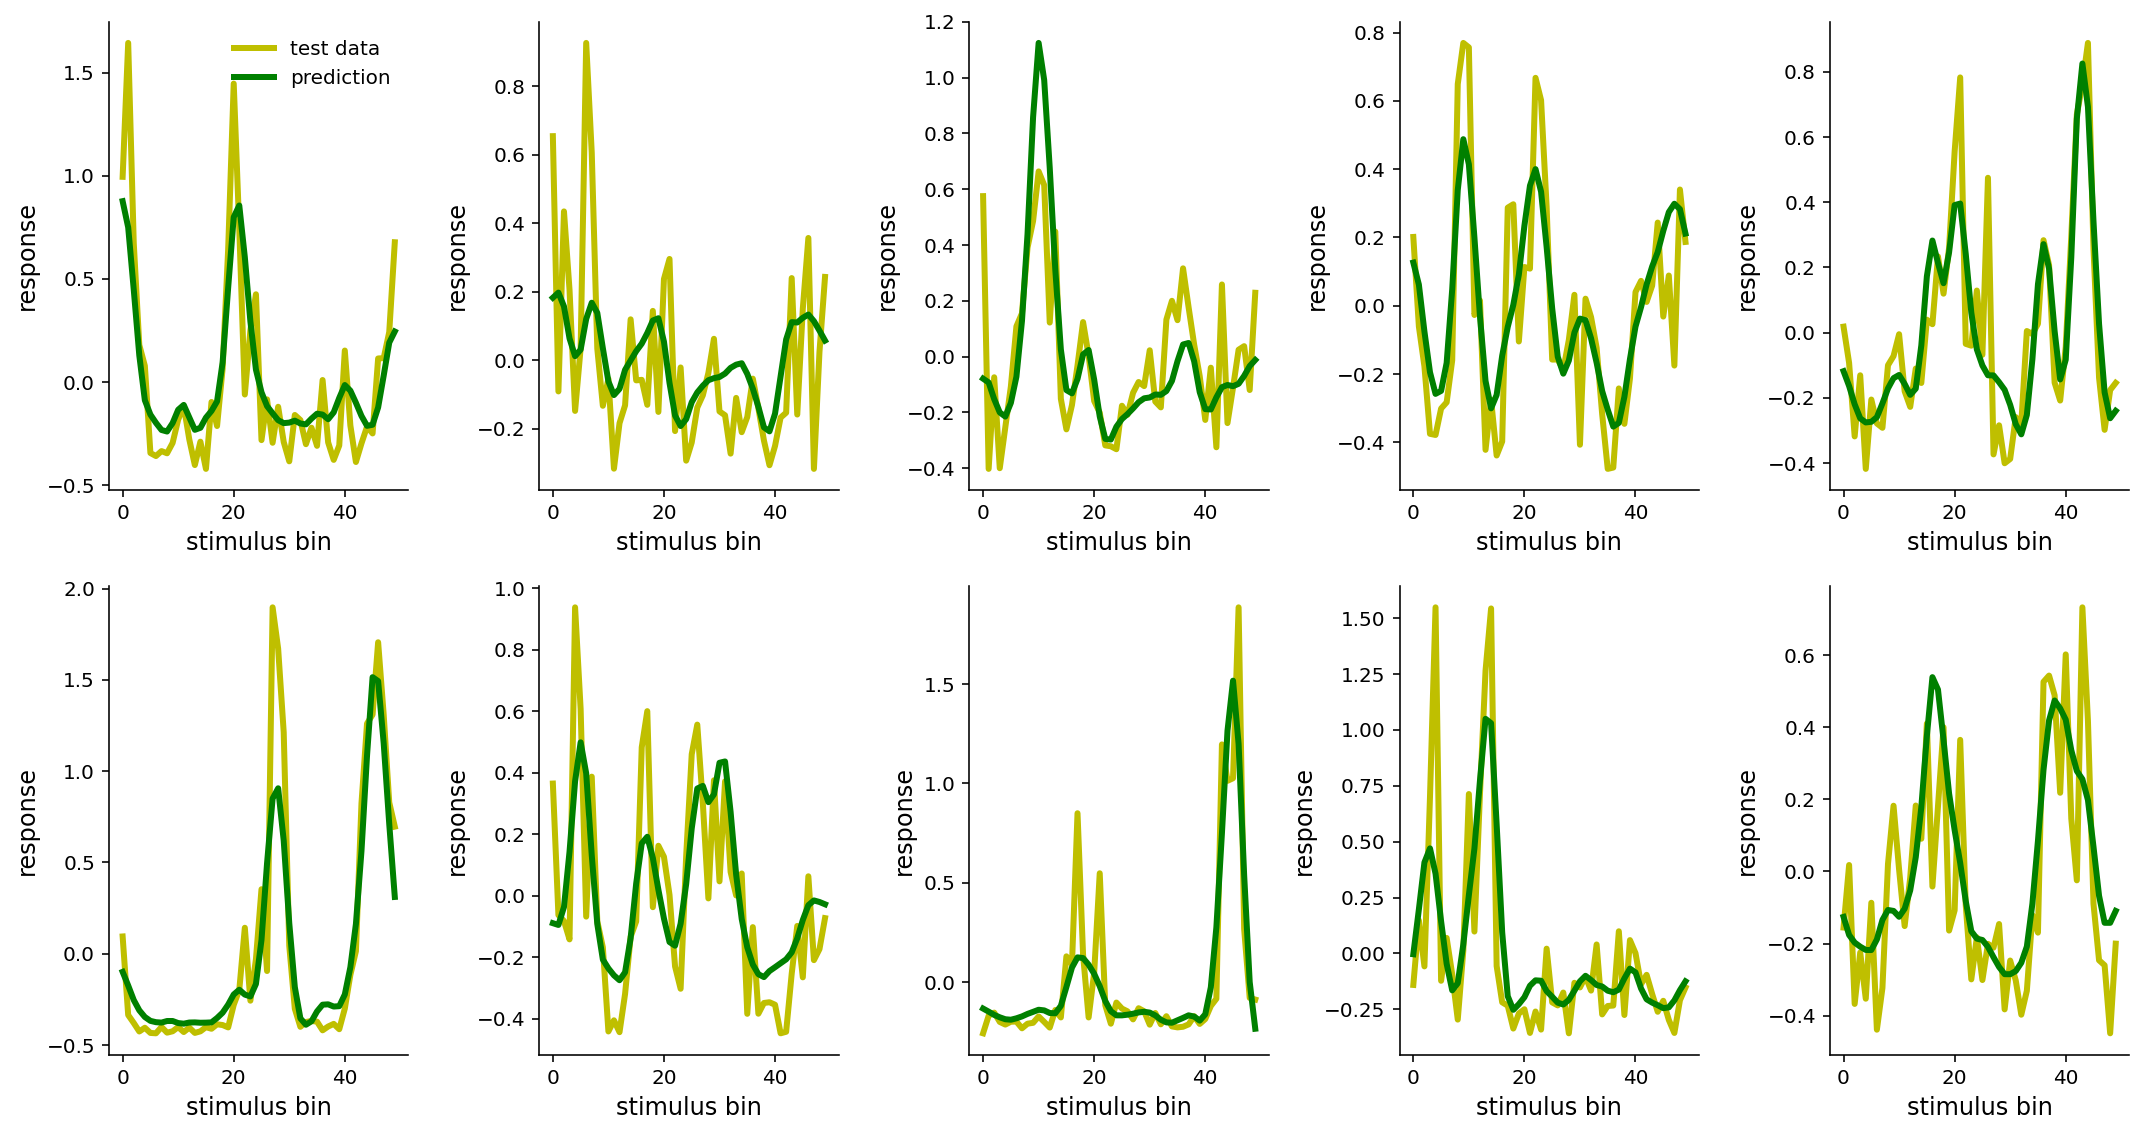

In [22]:
# plot some neural predictions 
respbin_pred = net(stim_binary).detach()

# Visualize tuning curves
fig, axs = plt.subplots(2, 5, figsize=(15,8))
for k, ax in enumerate(axs.flatten()):
  ineur = np.random.choice(n_neurons)
  plot_prediction(ax, respbin_pred[:,ineur], respbin_test[:,ineur])
  if k==0:
    ax.legend(['test data', 'prediction'])
fig.tight_layout()
plt.show()


---
## Summary

In this notebook, we built and evaluated a neural network based encoding model to predict neural responses from stimuli. To do so we :
* implemented a basic convolution filter
* implemented and trained a convolutional neural network with multiple filters to predict neural responses using PyTorch
* learned and implemented L2/L1 regularization to avoid overfitting

#### Bonus: Exercise 5 

Change the `L1_penalty` and `L2_penalty` and observe how the fits to data change. Can you predict what might happen when you increase or decrease these terms?